# **Model Selection**

We build and evaluate models using **Random Forest, XGBoost, Linear Regression, and Gaussian Process Regression**. 

## **1. Retrieving the data**

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [3]:
spyPre_raw = pd.read_csv("/Users/faridaliniaeifard/Documents/option_pricing/data/processed/edaSpy.csv")
spyPre_raw.head()

,Unnamed: 0,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume
0,0,300.0,295.04,0.000000,240.0,2.765628,True,4 days,593.669983,46750300.0
1,1,535.0,55.00,0.000000,1.0,0.544926,True,5 days,590.500000,50032600.0
2,2,540.0,55.04,-0.379997,2.0,0.664554,True,4 days,593.669983,46750300.0
3,3,550.0,46.20,9.780003,1.0,0.564457,True,3 days,595.510010,38226400.0
4,4,560.0,34.84,5.889999,5.0,0.461675,True,3 days,595.510010,38226400.0


In [5]:
spyPre1 = spyPre_raw.drop("Unnamed: 0", axis = 1)
spyPre1.head()

,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume
0,300.0,295.04,0.000000,240.0,2.765628,True,4 days,593.669983,46750300.0
1,535.0,55.00,0.000000,1.0,0.544926,True,5 days,590.500000,50032600.0
2,540.0,55.04,-0.379997,2.0,0.664554,True,4 days,593.669983,46750300.0
3,550.0,46.20,9.780003,1.0,0.564457,True,3 days,595.510010,38226400.0
4,560.0,34.84,5.889999,5.0,0.461675,True,3 days,595.510010,38226400.0


In [7]:
spyPre1.timeToCall = spyPre1.timeToCall.str.replace('days', '')
spyPre = spyPre1
spyPre.timeToCall = spyPre1.timeToCall.astype('int')
spyPre.head()

,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume
0,300.0,295.04,0.000000,240.0,2.765628,True,4,593.669983,46750300.0
1,535.0,55.00,0.000000,1.0,0.544926,True,5,590.500000,50032600.0
2,540.0,55.04,-0.379997,2.0,0.664554,True,4,593.669983,46750300.0
3,550.0,46.20,9.780003,1.0,0.564457,True,3,595.510010,38226400.0
4,560.0,34.84,5.889999,5.0,0.461675,True,3,595.510010,38226400.0


In [9]:
spyPre = spyPre.dropna()

spyPre.isnull().sum()

strike               0
lastPrice            0
change               0
openInterest         0
impliedVolatility    0
inTheMoney           0
timeToCall           0
Close                0
Volume               0
dtype: int64

## **2. Splitting the Data into Training and Test Sets**

Before applying PCA, we split our dataset into training and test sets.

In [12]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and y is your target variable
X = spyPre.drop('lastPrice', axis=1)  # Replace 'target' with your target column name
y = spyPre['lastPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **3. Standardize the Data**
We standardize the training data and use the same transformation on the test data.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## **4. Defining and Tuning the Models**

In [18]:
!pip install xgboost

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Defining the parameter grids for each model
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}

param_grid_lr = {
'fit_intercept': [True, False],  
    'positive': [True, False],  
}

# Defining Gaussian Process with a basic kernel
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
param_grid_gpr = {
    'alpha': [1e-10, 1e-2, 1],
    'kernel': [kernel]
}

# Creating the models
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lr = LinearRegression()
gpr = GaussianProcessRegressor()

# Performing grid search with cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gpr = GridSearchCV(gpr, param_grid_gpr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fitting the models
grid_search_rf.fit(X_train_scaled, y_train)
grid_search_xgb.fit(X_train_scaled, y_train)
grid_search_lr.fit(X_train_scaled, y_train)
grid_search_gpr.fit(X_train_scaled, y_train)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:44

GridSearchCV(cv=5, estimator=GaussianProcessRegressor(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 0.01, 1],
                         'kernel': [1**2 * RBF(length_scale=1)]},
             scoring='neg_mean_squared_error')

## **5. Compare the Models**

In [28]:
from sklearn.metrics import mean_squared_error

# Getting the best models from the grid search
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_lr = grid_search_lr.best_estimator_
best_gpr = grid_search_gpr.best_estimator_

# Predicting on the test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_gpr = best_gpr.predict(X_test_scaled)

# Evaluatting the models
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_gpr = mean_squared_error(y_test, y_pred_gpr)

print(f'MSE Random Forest: {mse_rf}')
print(f'MSE XGBoost: {mse_xgb}')
print(f'MSE Linear Regression: {mse_lr}')
print(f'MSE Gaussian Process: {mse_gpr}')


MSE Random Forest: 11.014016506721617
MSE XGBoost: 6.449081404113203
MSE Linear Regression: 664.5548936001961
MSE Gaussian Process: 19.21031532374498


**We see that MSE for XGboost is quite better than the other models.**

## **6. Comparing XGboost with Black-Scholes**

### **6.1 Annual Volatility**

In [33]:
def annual_volatility(ticker):
    #Calculate the annual volatility of a stock with the ticker 'ticker'.
    
    data = yf.download(ticker, start="2023-01-01", end="2024-01-01")

    #Calculate daily log returns
    data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

    #Calculate the daily volatility (standard deviation of log returns)
    daily_volatility = data['log_return'].std()

    #Annualize the volatility (252 trading days in a year)
    annual_volat = daily_volatility * np.sqrt(252)

    return annual_volat
    

## **6.2 Black-Scholes model**

In [36]:
from scipy.stats import norm

def black_scholes(df):
    """
    Calculate the Black-Scholes price for a European option.

    Parameters:
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free interest rate (annual)
    
    option_type : str, optional
        Type of the option ('call' or 'put'). Default is 'call'.

    Returns:
    float
        Black-Scholes price of the option
    """
    #sigma : Volatility of the stock (annual)
    sigma = annual_volatility('SPY')
    S = df['Close']
    K = df['strike']
    T = df['timeToCall']/365.25
    r=0.04
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return option_price



In [38]:
spyStockOption1 = pd.read_csv("/Users/faridaliniaeifard/Documents/option_pricing/data/processed/edaSpy.csv")

spyStockOption1.head()

,Unnamed: 0,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume
0,0,300.0,295.04,0.000000,240.0,2.765628,True,4 days,593.669983,46750300.0
1,1,535.0,55.00,0.000000,1.0,0.544926,True,5 days,590.500000,50032600.0
2,2,540.0,55.04,-0.379997,2.0,0.664554,True,4 days,593.669983,46750300.0
3,3,550.0,46.20,9.780003,1.0,0.564457,True,3 days,595.510010,38226400.0
4,4,560.0,34.84,5.889999,5.0,0.461675,True,3 days,595.510010,38226400.0


In [40]:
spyStockOption1.timeToCall = spyStockOption1.timeToCall.str.replace('days', '')
spyStockOption = spyStockOption1
spyStockOption.timeToCall = spyStockOption1.timeToCall.astype('int')
spyStockOption.head()

,Unnamed: 0,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume
0,0,300.0,295.04,0.000000,240.0,2.765628,True,4,593.669983,46750300.0
1,1,535.0,55.00,0.000000,1.0,0.544926,True,5,590.500000,50032600.0
2,2,540.0,55.04,-0.379997,2.0,0.664554,True,4,593.669983,46750300.0
3,3,550.0,46.20,9.780003,1.0,0.564457,True,3,595.510010,38226400.0
4,4,560.0,34.84,5.889999,5.0,0.461675,True,3,595.510010,38226400.0


In [42]:
spyStockOptionD = spyStockOption.drop("Unnamed: 0", axis = 1)
spyStockOptionD.head()

,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume
0,300.0,295.04,0.000000,240.0,2.765628,True,4,593.669983,46750300.0
1,535.0,55.00,0.000000,1.0,0.544926,True,5,590.500000,50032600.0
2,540.0,55.04,-0.379997,2.0,0.664554,True,4,593.669983,46750300.0
3,550.0,46.20,9.780003,1.0,0.564457,True,3,595.510010,38226400.0
4,560.0,34.84,5.889999,5.0,0.461675,True,3,595.510010,38226400.0


In [ ]:
spyStockOptionD['Black_Scholes'] = spyStockOptionD.apply(black_scholes ,axis = 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [62]:
spyStockOptionD.head()

,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume,Black_Scholes
0,300.0,295.04,0.000000,240.0,2.765628,True,4,593.669983,46750300.0,293.801371
1,535.0,55.00,0.000000,1.0,0.544926,True,5,590.500000,50032600.0,55.792870
2,540.0,55.04,-0.379997,2.0,0.664554,True,4,593.669983,46750300.0,53.906481
3,550.0,46.20,9.780003,1.0,0.564457,True,3,595.510010,38226400.0,45.690678
4,560.0,34.84,5.889999,5.0,0.461675,True,3,595.510010,38226400.0,35.693963


In [64]:
spyStockOptionD.to_csv("/Users/faridaliniaeifard/Documents/option_pricing/data/processed/after_black_scholes_4.csv")

In [66]:
withBlackScholes = pd.read_csv("/Users/faridaliniaeifard/Documents/option_pricing/data/processed/after_black_scholes_4.csv")
withBlackScholes.head()

,Unnamed: 0,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume,Black_Scholes
0,0,300.0,295.04,0.000000,240.0,2.765628,True,4,593.669983,46750300.0,293.801371
1,1,535.0,55.00,0.000000,1.0,0.544926,True,5,590.500000,50032600.0,55.792870
2,2,540.0,55.04,-0.379997,2.0,0.664554,True,4,593.669983,46750300.0,53.906481
3,3,550.0,46.20,9.780003,1.0,0.564457,True,3,595.510010,38226400.0,45.690678
4,4,560.0,34.84,5.889999,5.0,0.461675,True,3,595.510010,38226400.0,35.693963


In [68]:
withBlackScholes = withBlackScholes.dropna()

In [70]:
mse = mean_squared_error(withBlackScholes['lastPrice'], withBlackScholes['Black_Scholes'])
mse

14.968383820370885

In [108]:
Y_test_index_df = withBlackScholes[withBlackScholes.index.isin(Y_test_df.index)]

Y_test_index_df.head()

,Unnamed: 0,strike,lastPrice,change,openInterest,impliedVolatility,inTheMoney,timeToCall,Close,Volume,Black_Scholes
0,0,300.0,295.04,0.000000,240.0,2.765628,True,4,593.669983,46750300.0,293.801371
7,7,575.0,20.35,0.809999,34.0,0.302985,True,3,595.510010,38226400.0,20.701694
12,12,580.0,15.60,0.970000,460.0,0.195076,True,3,595.510010,38226400.0,15.729713
14,14,582.0,12.75,-0.170000,367.0,0.167977,True,3,595.510010,38226400.0,13.766510
17,17,585.0,10.88,1.200000,1085.0,0.140878,True,3,595.510010,38226400.0,10.893718


In [103]:
mse_Black_Scholes = mean_squared_error(Y_test_index_df['lastPrice'], Y_test_index_df['Black_Scholes'])
mse_Black_Scholes

16.123518964387124

## **Conclusion: XGBoost outperforms Black-Scholes Model**

In [5]:
dic = {"Random Forest": [11.014016506721617],
"XGBoost": [6.449081404113203],
"Linear Regression": [664.5548936001961],
"Gaussian Process": [19.21031532374498],
      "Black-Scholes" : [16.123518964387124]}

df_mse = pd.DataFrame(dic, index = ["MSE"])
df_mse



,Random Forest,XGBoost,Linear Regression,Gaussian Process,Black-Scholes
MSE,11.014017,6.449081,664.554894,19.210315,16.123519


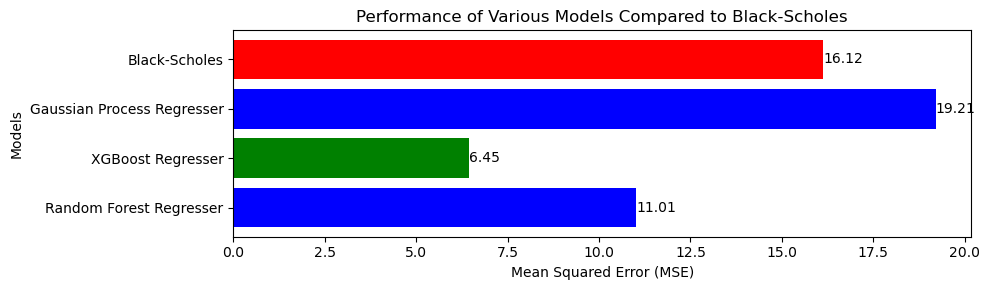

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Data dictionary
dic = {
    "Random Forest Regresser": [11.014016506721617],
    "XGBoost Regresser": [6.449081404113203],
    "Gaussian Process Regresser": [19.21031532374498],
    "Black-Scholes": [16.123518964387124]
}
df_mse = pd.DataFrame(dic, index = ["MSE"])
# Plotting the bar graph horizontally
plt.figure(figsize=(10, 3))
bars = plt.barh(df_mse.columns, df_mse.loc["MSE"], color=['blue', 'green', 'blue', 'red', 'red'])
plt.ylabel('Models')
plt.xlabel('Mean Squared Error (MSE)')
plt.title('Performance of Various Models Compared to Black-Scholes')

# Adding MSE values on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 2), va='center')  # va: vertical alignment

# Show plot
plt.tight_layout()
plt.show()
plt.savefig('performance.png')